# Load libraries

In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

%load_ext rpy2.ipython

In [2]:
%%R 
library(tidyverse)
library(cowplot)
library(ggforce)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Load data

In [3]:
%%R -o best_hits

#reads best_hits file from cinful output
best_hits <- read_csv("data/Ecoli_pangenome_best_hits.csv")

Rows: 7262 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): qseqid, sseqid, component, cinful_id, pephash, sample, contig, seq
dbl (13): pident, length, mismatch, gapopen, qstart, qend, sstart, send, eva...
lgl  (4): hmmerHit, verified, allStandardAA, signalMatch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
#Selects only HMM verified proteins 
best_hits = best_hits[best_hits["hmmerHit"] == True]

In [5]:
%%R -o best_MFP_hits

#reads best_MFP_candidates from cinful output
best_MFP_hits <- read_csv("data/Ecoli_pangenome_best_MFP_candidates.csv")

Rows: 136 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): cinful_id, pephash, sample, contig, seq, cvab_hit
dbl (3): start, stop, strand
lgl (1): allStandardAA

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The goal here is to breakdown the assemblies with microcins into the following categories
1. novel
2. pcat
3. mfp
4. immunity

novel is already taken care of from the default cinful output.

For pcat we just look at best hits for CvaB and see if those headers match up with the other hits. For MFP, we will need the separate output file. Then take those headers and determine which PCAT hits also had a MFP hit.

In [6]:
#Creates pcat_hits (subset of best_hits selecting for CvaB.verified)
pcat_hits = best_hits[best_hits["component"] == "CvaB.verified"]

#Display results
pcat_hits.shape[0]

264

In [7]:
#Matches the contig of the PCAT hit to the MFP hit and creates file pcat 
pcat_hits_MFP = pcat_hits[pcat_hits["sample"].isin(best_MFP_hits["sample"])]

#Display results
pcat_hits_MFP.shape[0]

133

In [8]:
#Creates a subset of best_hits only containing the immunity proteins
best_hits_immunity_protein = best_hits[best_hits["component"] == "immunity_proteins.verified"]

#Creates a subset of best_hits only containing the microcins
microcin_hits_all = best_hits[best_hits["component"] == "microcins.verified"]

In [9]:
#Creates column "pcat_hits_assembly" and marks T/F if sample names match between microcin and pcat_hits
microcin_hits_all["pcat_hits_assembly"] = microcin_hits_all["sample"].isin(pcat_hits["sample"])

#Creates column "mfp_hits_assembly" and marks T/F if  samples names match between microcin and pcat_hits_MFP
#microcin_hits_all["mfp_hits_assembly"] = microcin_hits_all["sample"].isin(pcat_hits_MFP["sample"])

#Creates column "mfp_hits_assembly" and marks T/F if  samples names match between microcin and pcat_hits_MFP
microcin_hits_all["mfp_hits_assembly"] = microcin_hits_all["sample"].isin(pcat_hits_MFP["sample"])

#Creates column "immunity_contig" and marks T/F if samples names match between microcin and immunity proteins
microcin_hits_all["immunity_contig"] = microcin_hits_all["contig"].isin(best_hits_immunity_protein["contig"])

#Creates column "immunity_genome" and marks T/F if samples names match between microcin and immunity proteins
microcin_hits_all["immunity_genome"] = microcin_hits_all["sample"].isin(best_hits_immunity_protein["sample"])

#Creates a verified subset of microcin_hits using HMMer hits (recorded from cinful) 
microcin_hits_verified = microcin_hits_all[microcin_hits_all["hmmerHit"] == True]

#Display output
microcin_hits_verified

/tmp/ipykernel_68210/971208938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  microcin_hits_all["pcat_hits_assembly"] = microcin_hits_all["sample"].isin(pcat_hits["sample"])
/tmp/ipykernel_68210/971208938.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  microcin_hits_all["mfp_hits_assembly"] = microcin_hits_all["sample"].isin(pcat_hits_MFP["sample"])
/tmp/ipykernel_68210/971208938.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,...,start,stop,strand,allStandardAA,seq,signalMatch,pcat_hits_assembly,mfp_hits_assembly,immunity_contig,immunity_genome
1,v1_PLS_987b1ca9af3c15dc3808bbe391c1997d4460e83...,E492_sp_Q9Z4N4_MCEA_KLEPN,80.435,92.0,18.0,0.0,1.0,92.0,1.0,92.0,...,1899.0,2198.0,1.0,1,MREISQRDLYQVLGAGNTDPNTQLLKDLANNMAWGAALGAKGGLGT...,0,False,False,True,True
2,v1_PLS_0719676e795eaed3af7fb25fcc33805c9c4a269...,L_tr_Q841V4_Q841V4_ECOLX,99.020,102.0,1.0,0.0,1.0,102.0,4.0,105.0,...,3.0,311.0,1.0,1,ITLNEMNNVSGAGDVNWVDVGKTVATNGAGVIGGAFGAGLCGPVCA...,1,True,True,False,False
3,v1_PLS_718e57ae56d43ffc2101f6669bfb90fa1293201...,V_sp_P22522_CEAV_ECOLX,81.250,16.0,3.0,0.0,1.0,16.0,1.0,16.0,...,71.0,223.0,-1.0,1,MRTLTLNELDAVSWGVNVTITVAQEYKWKRGKYSSLYYPSALLLAL...,1,True,True,False,False
4,v1_PLS_f46b02a1bfa1c3d276b482deec9926ec13d8dc5...,V_sp_P22522_CEAV_ECOLX,100.000,103.0,0.0,0.0,1.0,103.0,1.0,103.0,...,24390.0,24701.0,1.0,1,MRTLTLNELDSVSGGASGRDIAMAIGTLSGQFVAGGIGAAAGGVAG...,1,False,False,False,False
5,v1_PLS_f46b02a1bfa1c3d276b482deec9926ec13d8dc5...,V_sp_P22522_CEAV_ECOLX,100.000,103.0,0.0,0.0,1.0,103.0,1.0,103.0,...,3272.0,3583.0,1.0,1,MRTLTLNELDSVSGGASGRDIAMAIGTLSGQFVAGGIGAAAGGVAG...,1,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,v1_PLS_796a75914de7bf03f46239f1d355a033c9e7e1d...,M_tr_Q83TS1_Q83TS1_ECOLX,96.739,92.0,3.0,0.0,1.0,92.0,1.0,92.0,...,7652.0,7930.0,-1.0,1,MRKPSENEIKQISGGDGNDGQAELIAIGLLAGTFISPGFGSIAGAY...,1,True,False,True,True
400,v1_PLS_35f910179d2ac02cf732f6a7727f5add4e06277...,M_tr_Q83TS1_Q83TS1_ECOLX,40.625,32.0,19.0,0.0,14.0,45.0,17.0,48.0,...,2.0,268.0,1.0,1,ILSSRLGAGSPSAGNIAELDAIAACVIGGTSLAGGVGSVAGAVMGA...,0,False,False,False,False
401,v1_PLS_1cddbead564a238a4068fa38deea45eb3eccc20...,PDI_tr_I6ZU90_I6ZU90_ECOLX,97.500,120.0,3.0,0.0,1.0,120.0,1.0,120.0,...,47511.0,47873.0,-1.0,1,MASIRELTLDEITLVSGGNANSNFEGGPRNDRSSGARNSLGRNAPT...,1,True,False,False,False
402,v1_PLS_4ab3e15a6dc44de84c9f3fd57f8afd9b6a7f7af...,I47_tr_Q712Q0_Q712Q0_ECOLX,91.228,57.0,5.0,0.0,1.0,57.0,1.0,57.0,...,3012.0,3245.0,-1.0,1,MREISDHMLDFVKRGMNLNGLPSSTNVIDLRGKDMGTYIDANGACW...,0,True,False,False,False


In [10]:
#Create subset of microcin hits with only sample, contig, and pephash(for microcin)
mc = microcin_hits_verified.loc[:, ('sample', 'contig','pephash')]

#Create subset of immunity protein hits with sample and contig
ip = best_hits_immunity_protein.loc[:, ('sample', 'contig')]

#Merge mc and ip, ensuring sample and contig hits. pephash(mc) will carry over for matches
#This DF contains samples where the pephash meets immunity standard, therefore if sample and pephash match,
#we know there is an immunity protein ON THIS GENOME for this specific microcin
mc_to_ip_pephash = mc.merge(ip, how = 'inner', on = ['sample', 'contig'])

#Merging the sample and pephash of the verified microcins to the contig match from above
#This results in a df that has sample and pephash verification, matching to a known immunity protein
genome_and_pep_match = microcin_hits_verified.merge(mc_to_ip_pephash, how = 'inner', on = ['sample', 'pephash'])

#Final result creates a new column, genome_provides_immunity, that shows where an immunity protein
#is present on the genome, matches the pephash from the microcin, and provides immunity to that specific microcin
microcin_hits_verified["genome_provides_immunity"] = microcin_hits_verified["sample"].isin(genome_and_pep_match["sample"])

#New column, final_immunity, that includes both genome/pephash matches AND contig matches
microcin_hits_verified["final_immunity"] = (microcin_hits_verified["contig"].isin(best_hits_immunity_protein["contig"]) | microcin_hits_verified["genome_provides_immunity"])

In [11]:
%%R -i microcin_hits_verified
microcin_hits_verified_melt <- 
microcin_hits_verified %>%
	as.tibble() %>%
	mutate(a_component = case_when(
		component == "microcins.verified" ~ "assemblies"
	)) %>%
	mutate(b_verified = case_when(
		verified == 0 ~ "Novel Microcin",
		verified == 1 ~ "Verified Microcin"
	)) %>%
	# mutate(c_signalMatch = case_when(
	# 	signalMatch == 0 ~ "no signal",
	# 	signalMatch == 1 ~ "signal"
	# )) %>%
	mutate(c_pcat_hits_assembly = case_when(
		pcat_hits_assembly == TRUE ~ "Contains PCAT",
		pcat_hits_assembly == FALSE ~ "PCAT Absent"
	)) %>%
	mutate(d_mfp_hits_assembly = case_when(
		mfp_hits_assembly == TRUE ~ "Contains MFP",
		mfp_hits_assembly == FALSE ~ "MFP Absent"
	)) %>%
	mutate(e_immunity_contig = case_when(
		final_immunity == TRUE ~ "Contains IP",
		final_immunity == FALSE ~ "IP Absent"
    )) %>%
#	mutate(e_immunity_contig = case_when(
#		immunity_contig == TRUE ~ "Contig w/Immunity Protein",
#		immunity_contig == FALSE ~ "No Immunity Protein"
#    )) %>%
#	mutate(f_immunity_genome = case_when(
#		immunity_genome == TRUE ~ "Genome Contains Immunity Protein",
#		immunity_genome == FALSE ~ "no immunity"
#	)) %>%
	group_by(a_component,b_verified, 
	# c_signalMatch, 
	c_pcat_hits_assembly, d_mfp_hits_assembly,
	e_immunity_contig) %>%
	summarise(n = n()) %>%
	reshape2::melt() %>%
	gather_set_data(1:5) %>%
	as.tibble() #%>%

microcin_hits_verified_melt

`summarise()` has grouped output by 'a_component', 'b_verified',
'c_pcat_hits_assembly', 'd_mfp_hits_assembly'. You can override using the
`.groups` argument.


R[write to console]: Using a_component, b_verified, c_pcat_hits_assembly, d_mfp_hits_assembly, e_immunity_contig as id variables



# A tibble: 60 × 10
   a_component b_verified     c_pcat_hits_ass… d_mfp_hits_asse… e_immunity_cont…
   <chr>       <chr>          <chr>            <chr>            <chr>           
 1 assemblies  Novel Microcin Contains PCAT    Contains MFP     Contains IP     
 2 assemblies  Novel Microcin Contains PCAT    Contains MFP     IP Absent       
 3 assemblies  Novel Microcin Contains PCAT    MFP Absent       Contains IP     
 4 assemblies  Novel Microcin Contains PCAT    MFP Absent       IP Absent       
 5 assemblies  Novel Microcin PCAT Absent      MFP Absent       Contains IP     
 6 assemblies  Novel Microcin PCAT Absent      MFP Absent       IP Absent       
 7 assemblies  Verified Micr… Contains PCAT    Contains MFP     Contains IP     
 8 assemblies  Verified Micr… Contains PCAT    Contains MFP     IP Absent       
 9 assemblies  Verified Micr… Contains PCAT    MFP Absent       Contains IP     
10 assemblies  Verified Micr… Contains PCAT    MFP Absent       IP Absent       
# … with

In [12]:
%%R

#Save output in supplemental data
microcin_hits_verified_melt %>%
	write_csv("data/supplemental/Ecoli_microcin_sankey_data.csv")

Joining, by = "y"


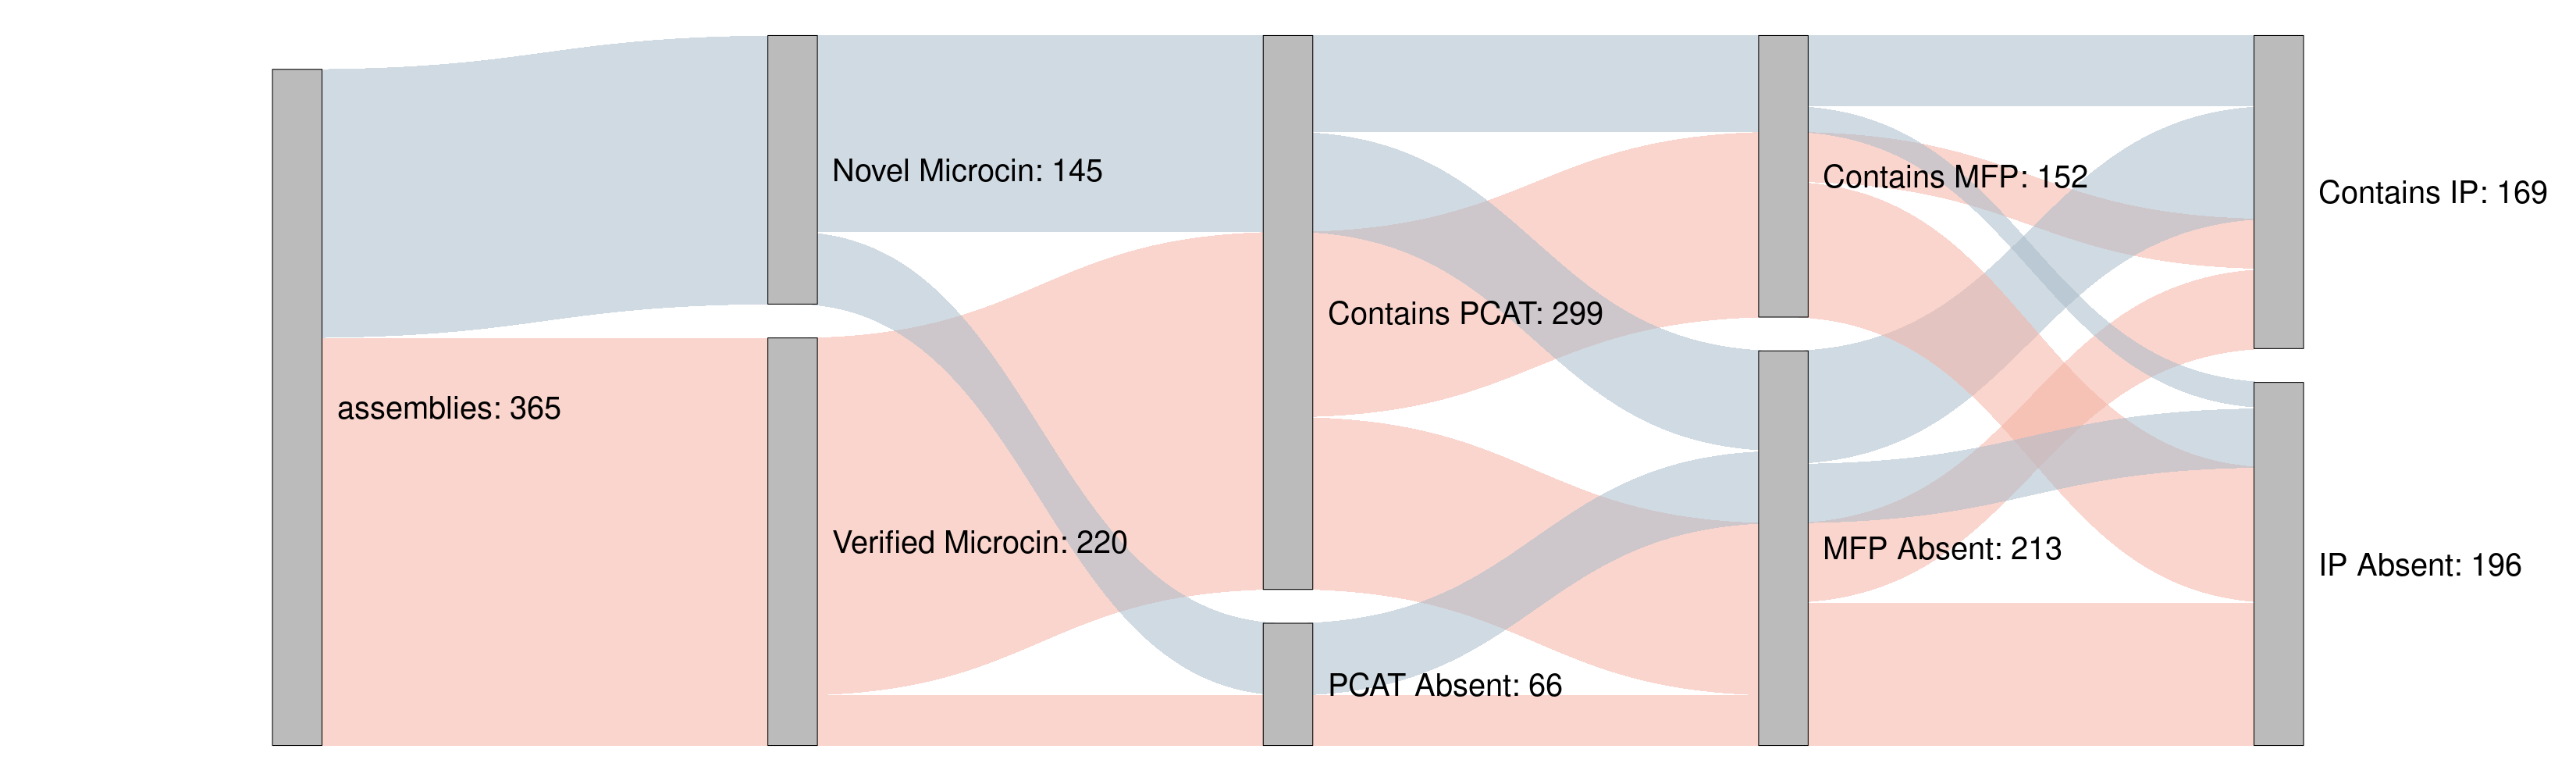

In [13]:
%%R -w 3300 -h 1000
microcin_hits_verified_melt %>%
	group_by(y) %>%
	summarise(sum_value = sum(value)) %>%
	unite("category", c(y,sum_value), sep = ": ",remove = FALSE) %>%
	full_join(microcin_hits_verified_melt) %>%
	ggplot(aes(x, id = id, split = category, value = value)) +

# Next line "fill = *" determines the splits for the sankey plot
		geom_parallel_sets(aes(fill = b_verified, axis.width = 0.1,
			alpha=0.25
			)) +
		geom_parallel_sets_axes(axis.width = 0.1, color = "black", fill = "#BBBBBB") +
		geom_parallel_sets_labels(colour = "black" , angle = 0, 
			position = position_nudge(x = 0.08),  
			size = 14, 
			# face = "italic",
			hjust = 0
			) +
		scale_fill_manual(values=c("#AABBCA","#F4B3A5")) +
		# theme(text = element_text(size = 200))
		theme_nothing() #+
		# theme(text = element_text(size = 50))   


#Uncomment below to save
#ggsave("Figure_4_microcin_hits_verified_sankey.svg")
